## Consumer Discretionary Model

In [99]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import quandl
from sklearn.metrics import mean_absolute_percentage_error as mape, mean_absolute_error as mae
from functools import reduce


### Load target variable data

In [100]:
# Load P/E ratio -- data manually downloaded from Capital IQ
pe_ratio = pd.read_csv('../../data/raw/con_disc_pe_ratio.csv')
pe_ratio.head()

,Dates,S&P 500 Consumer Discretionary (Sector) (^SP500-25) - P/Normalized EPS
0,Aug-21-2001,31.70x
1,Aug-22-2001,31.80x
2,Aug-23-2001,31.69x
3,Aug-24-2001,32.48x
4,Aug-27-2001,32.17x


In [101]:
# load consumer discretionary index price -- also from Capital IQ
price = pd.read_csv('../../data/raw/con_disc_price.csv')
price.head()

,Dates,S&P 500 Consumer Discretionary (Sector) (^SP500-25) - Index Value
0,Sep-11-1989,77.33
1,Sep-12-1989,77.33
2,Sep-13-1989,76.32
3,Sep-14-1989,75.53
4,Sep-15-1989,75.66


In [102]:
# load 10 year treasury rate
quandl.ApiConfig.api_key = "_hLYTCZrYi9hepbQPNou"

treasury = quandl.get("FRED/DGS10")
treasury.head()

,Value
Date,
1962-01-02,4.06
1962-01-03,4.03
1962-01-04,3.99
1962-01-05,4.02
1962-01-08,4.03


### Transform

In [103]:
# rename, change type
pe_ratio = pe_ratio.rename(columns = {"Dates": "Date", "S&P 500 Consumer Discretionary (Sector) (^SP500-25) - P/Normalized EPS" : "PE"})
pe_ratio['Date'] = pd.to_datetime(pe_ratio['Date'])
pe_ratio = pe_ratio.set_index('Date')

pe_ratio['PE'] = pe_ratio['PE'].str.rstrip('x')
pe_ratio['PE'] = pd.to_numeric(pe_ratio['PE'])
pe_ratio.head()

,PE
Date,
2001-08-21,31.70
2001-08-22,31.80
2001-08-23,31.69
2001-08-24,32.48
2001-08-27,32.17


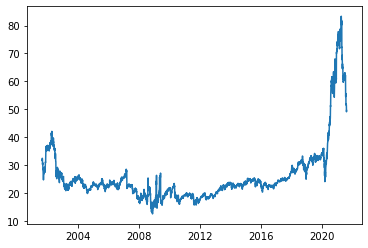

In [104]:
plt.plot(pe_ratio.PE)

In [105]:
# rename, change type
price = price.rename(columns = {"Dates": "Date", "S&P 500 Consumer Discretionary (Sector) (^SP500-25) - Index Value" : "Price"})
price['Date'] = pd.to_datetime(price['Date'])
price = price.set_index('Date')

price.head()

,Price
Date,
1989-09-11,77.33
1989-09-12,77.33
1989-09-13,76.32
1989-09-14,75.53
1989-09-15,75.66


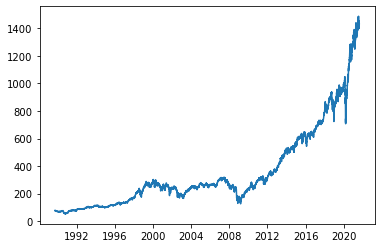

In [106]:
plt.plot(price.Price)

In [107]:
treasury = treasury.rename(columns = {"Value" : "treasury_rate"})
treasury.head()

,treasury_rate
Date,
1962-01-02,4.06
1962-01-03,4.03
1962-01-04,3.99
1962-01-05,4.02
1962-01-08,4.03


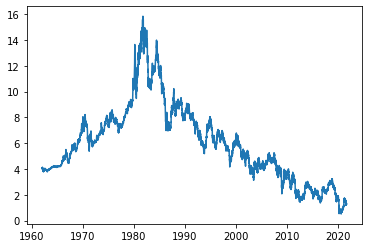

In [108]:
plt.plot(treasury.treasury_rate)

### Transform to monthly average

In [109]:
joined = pe_ratio.join(price).join(treasury)
joined.head()

,PE,Price,treasury_rate
Date,,,
2001-08-21,31.70,241.08,4.87
2001-08-22,31.80,241.63,4.91
2001-08-23,31.69,240.75,4.89
2001-08-24,32.48,246.84,4.93
2001-08-27,32.17,245.02,4.94


In [110]:
joined['month'] = joined.index.month
joined['year'] = joined.index.year

joined = joined.groupby([joined.year, joined.month]).mean()
joined.head()

PE       Price  treasury_rate
year month                                      
2001 8      31.516667  239.642222       4.867778
     9      27.175333  204.901333       4.748667
     10     28.268696  211.766087       4.566818
     11     33.669524  230.619524       4.651500
     12     36.054000  238.324500       5.087500

In [111]:
joined = joined.reset_index()
joined['date'] = pd.to_datetime(joined[['year', 'month']].assign(DAY=1))
joined = joined.set_index('date')
joined.head()

,year,month,PE,Price,treasury_rate
date,,,,,
2001-08-01,2001,8,31.516667,239.642222,4.867778
2001-09-01,2001,9,27.175333,204.901333,4.748667
2001-10-01,2001,10,28.268696,211.766087,4.566818
2001-11-01,2001,11,33.669524,230.619524,4.651500
2001-12-01,2001,12,36.054000,238.324500,5.087500


In [112]:
joined['earnings'] = joined.Price / joined.PE
joined.head()

,year,month,PE,Price,treasury_rate,earnings
date,,,,,,
2001-08-01,2001,8,31.516667,239.642222,4.867778,7.603666
2001-09-01,2001,9,27.175333,204.901333,4.748667,7.539975
2001-10-01,2001,10,28.268696,211.766087,4.566818,7.491187
2001-11-01,2001,11,33.669524,230.619524,4.651500,6.849504
2001-12-01,2001,12,36.054000,238.324500,5.087500,6.610210


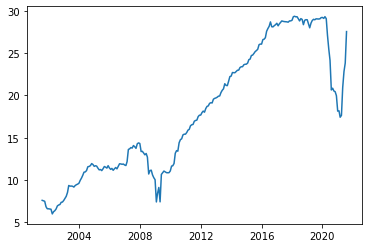

In [113]:
plt.plot(joined.earnings)

In [114]:
joined['earnings_change'] = joined.earnings.pct_change()
display(joined)

,year,month,PE,Price,treasury_rate,earnings,earnings_change
date,,,,,,,
2001-08-01,2001,8,31.516667,239.642222,4.867778,7.603666,NaN
2001-09-01,2001,9,27.175333,204.901333,4.748667,7.539975,-0.008376
2001-10-01,2001,10,28.268696,211.766087,4.566818,7.491187,-0.006471
2001-11-01,2001,11,33.669524,230.619524,4.651500,6.849504,-0.085658
2001-12-01,2001,12,36.054000,238.324500,5.087500,6.610210,-0.034936
...,...,...,...,...,...,...,...
2021-04-01,2021,4,80.362500,1417.672000,1.628000,17.640964,0.012511
2021-05-01,2021,5,65.739500,1376.421500,1.621000,20.937511,0.186869
2021-06-01,2021,6,60.907368,1390.399474,1.524211,22.828100,0.090297


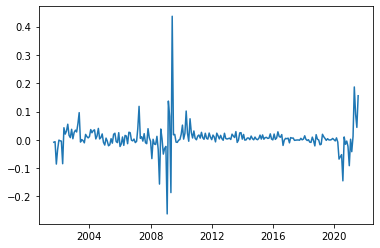

In [115]:
plt.plot(joined.earnings_change)

In [116]:
joined['target'] = joined.earnings_change - ((1 + joined.treasury_rate/100)**(1/12) - 1)
joined = joined.dropna()
joined.head()

,year,month,PE,Price,treasury_rate,earnings,earnings_change,target
date,,,,,,,,
2001-09-01,2001,9,27.175333,204.901333,4.748667,7.539975,-0.008376,-0.012250
2001-10-01,2001,10,28.268696,211.766087,4.566818,7.491187,-0.006471,-0.010199
2001-11-01,2001,11,33.669524,230.619524,4.651500,6.849504,-0.085658,-0.089454
2001-12-01,2001,12,36.054000,238.324500,5.087500,6.610210,-0.034936,-0.039080
2002-01-01,2002,1,36.128095,238.579524,5.035714,6.603712,-0.000983,-0.005086


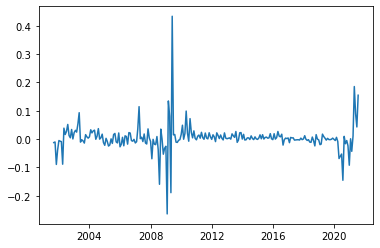

In [117]:
plt.plot(joined.target)

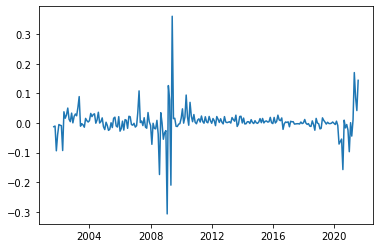

In [118]:
joined['logged_target'] = np.log(1 + joined.target)
plt.plot(joined.logged_target)

In [119]:
target = joined['target'].to_frame()
target.head()

,target
date,
2001-09-01,-0.012250
2001-10-01,-0.010199
2001-11-01,-0.089454
2001-12-01,-0.039080
2002-01-01,-0.005086


## SARIMA Model

In [120]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")
import pmdarima as pm

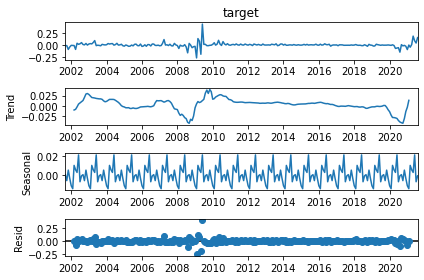

In [121]:
# look at seasonality
decomp_results = seasonal_decompose(target['target'], period = 12)
decomp_results.plot()
plt.show()

In [122]:
# train test split
split_date = pd.Timestamp('2017-01-01')

train = target.loc[:split_date]
y_train = train['target']

test =  target.loc[split_date:]
y_test = test['target']

In [123]:
results = pm.auto_arima(y_train, seasonal = True, m = 12, D = 1, information_criterion = 'aic')
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  185
Model:             SARIMAX(3, 0, 0)x(2, 1, 0, 12)   Log Likelihood                 257.478
Date:                            Wed, 25 Aug 2021   AIC                           -502.957
Time:                                    22:21:41   BIC                           -484.037
Sample:                                         0   HQIC                          -495.281
                                            - 185                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1859      0.044     -4.192      0.000      -0.273      -0.099
ar.L2          0.0276      0.049   

In [124]:
sarimax_model = SARIMAX(y_train, 
                order = (3,0,1), 
                seasonal_order = (2,1,1,12)
                # , exog = x_train
                )

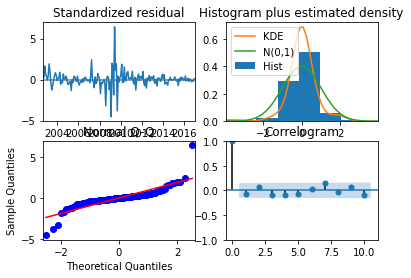

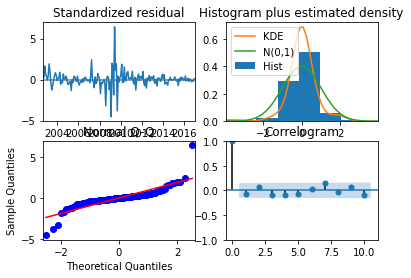

In [125]:
sarimax_mod_fit = sarimax_model.fit()
sarimax_mod_fit.plot_diagnostics()

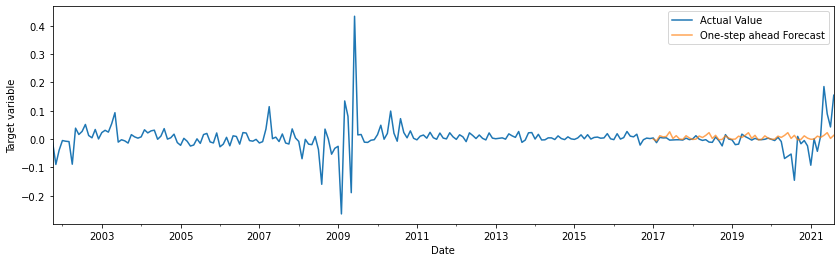

In [126]:
sarimax_pred = sarimax_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1])

sar_pred = sarimax_pred.predicted_mean
sar_pred_ci = sarimax_pred.conf_int()
ax = target.target['2001-10-01':].plot(label='Actual Value')
sar_pred.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.legend()
plt.show()

In [127]:
print("MAPE:", round(mape(y_test, sar_pred), 3))
print("MAE:", round(mae(y_test, sar_pred), 3))

MAPE: 2.96
MAE: 0.025


## Holt Winter’s Exponential Smoothing

In [128]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# fit model
hwes_model = ExponentialSmoothing(y_train, seasonal = 'add', seasonal_periods = 12)
hwes_mod_fit = hwes_model.fit()

# make prediction
hwes_pred = hwes_mod_fit.predict(start = y_test.index[0], end = y_test.index[-1])

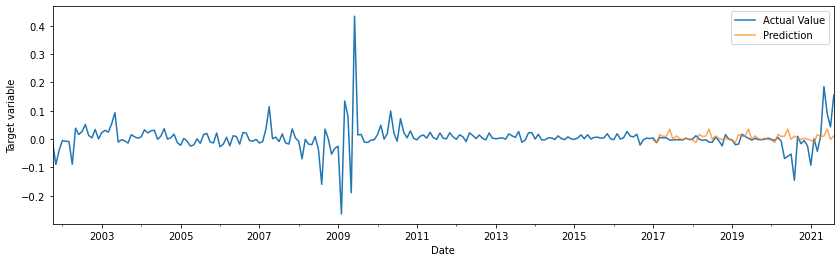

In [129]:
# plot
ax = target.target['2001-10-01':].plot(label='Actual Value')
hwes_pred.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))

ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.legend()
plt.show()

In [130]:
print("MAPE:", round(mape(y_test, hwes_pred), 3))
print("MAE:", round(mae(y_test, hwes_pred), 3))

MAPE: 3.336
MAE: 0.025


## Load exogenous Variables

In [131]:
def get_df_name(df):
    # grabs name of dataframe to be used as variable name
    name =[x for x in globals() if globals()[x] is df][0]
    return name

def var_change(df):
    df_name = get_df_name(df)
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['Date'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1))
    df = df.set_index('Date')

    df = df.rename(columns = {'Value':df_name}).drop(columns = ['year', 'month'])

    df_mom_ch = df.rename(columns = {df_name : df_name + '_mom_ch'})
    df_mom_ch = df_mom_ch[df_name + '_mom_ch'].diff(1)/ df_mom_ch[df_name + '_mom_ch']

    df_yoy_ch = df.rename(columns = {df_name : df_name + '_yoy_ch'})
    df_yoy_ch = df_yoy_ch[df_name + '_yoy_ch'].diff(12)/ df_yoy_ch[df_name + '_yoy_ch']

    df_final = pd.DataFrame(df_mom_ch).join(df_yoy_ch).join(df)
    
    return df_final

### Covid Boolean

In [132]:
covid = pd.read_csv('../../data/raw/COVID_Boolean.csv')
covid['Date'] = pd.to_datetime(covid['Date'])
covid = covid.set_index(['Date'])
covid.head()

,COVID_Boolean
Date,
2000-01-01,0
2000-02-01,0
2000-03-01,0
2000-04-01,0
2000-05-01,0


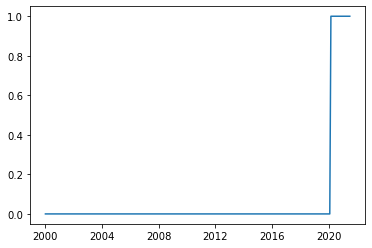

In [133]:
plt.plot(covid.COVID_Boolean)

### COVID Vaccination Rate

In [134]:
vaccines = pd.read_csv('../../data/raw/cumulative-covid-vaccinations.csv')
vaccines = vaccines.set_index(['Entity'])
vaccines = vaccines.rename(columns = {"Day": "Date"})
vaccines['Date'] = pd.to_datetime(vaccines['Date'])
vaccines.head()

,Code,Date,total_vaccinations
Entity,,,
Afghanistan,AFG,2021-02-22,0
Afghanistan,AFG,2021-02-28,8200
Afghanistan,AFG,2021-03-16,54000
Afghanistan,AFG,2021-04-07,120000
Afghanistan,AFG,2021-04-22,240000


In [135]:
# filter to only US covid vaccinations
vac = vaccines.loc[('United States'), :]
vac = vac.reset_index().set_index('Date')

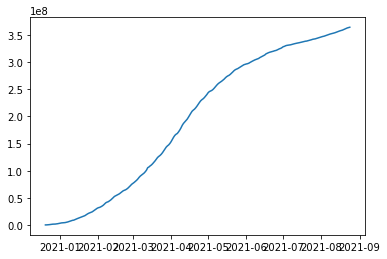

In [136]:
plt.plot(vac.total_vaccinations)

In [137]:
vac['month'] = vac.index.month
vac['year'] = vac.index.year
vac = vac.groupby([vac.year, vac.month]).mean()
vac = vac.reset_index()
vac['Date'] = pd.to_datetime(vac[['year', 'month']].assign(DAY=1))
vac = vac.set_index('Date')

vac['vac_mom_ch'] = vac.total_vaccinations.diff(1)
vac = vac.drop(['year', 'month'], 1)
vac.head()

,total_vaccinations,vac_mom_ch
Date,,
2020-12-01,1.507444e+06,NaN
2021-01-01,1.585593e+07,1.434848e+07
2021-02-01,5.242682e+07,3.657089e+07
2021-03-01,1.119633e+08,5.953650e+07
2021-04-01,1.991314e+08,8.716811e+07


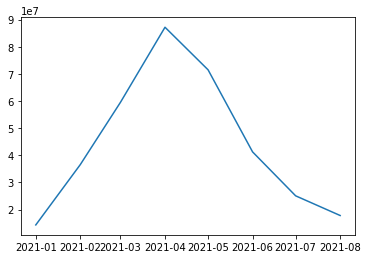

In [138]:
plt.plot(vac.vac_mom_ch)

## Load Quandl indicators

In [139]:
# PCEPILFE - Personal Consumption Expenditures Excluding Food and Energy (Chain-Type Price Index) 
pce = quandl.get('FRED/PCEPILFE')
pce.head()

,Value
Date,
1959-01-01,16.688
1959-02-01,16.701
1959-03-01,16.719
1959-04-01,16.762
1959-05-01,16.783


In [140]:
# CPIAUCSL - Consumer Price Index for All Urban Consumers: All Items in U.S. City Average 
cpi = quandl.get('FRED/CPIAUCSL')
cpi.head()

,Value
Date,
1947-01-01,21.48
1947-02-01,21.62
1947-03-01,22.00
1947-04-01,22.00
1947-05-01,21.95


In [141]:
# UNRATE - Unemployment Rate 
unemp = quandl.get('FRED/UNRATE')
unemp.head()

,Value
Date,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5


In [142]:
# PAYEMS - All Employees, Total Nonfarm
emp = quandl.get('FRED/PAYEMS')
emp.head()

,Value
Date,
1939-01-01,29923.0
1939-02-01,30100.0
1939-03-01,30280.0
1939-04-01,30094.0
1939-05-01,30299.0


In [143]:
# RRSFS - Advance Real Retail and Food Services Sales
rrfs = quandl.get('FRED/RRSFS')
rrfs.head()

,Value
Date,
1992-01-01,118651.0
1992-02-01,118480.0
1992-03-01,117700.0
1992-04-01,118156.0
1992-05-01,118548.0


In [144]:
# RSXFS - Advance Retail Sales: Retail Trade
rsxfs = quandl.get('FRED/RSXFS')
rsxfs.head()

,Value
Date,
1992-01-01,146925.0
1992-02-01,147223.0
1992-03-01,146805.0
1992-04-01,148032.0
1992-05-01,149010.0


In [145]:
# SOC1 - Consumer Sentiment
soc = quandl.get('UMICH/SOC1').rename(columns = {'Index':'Value'})
soc.head()

,Value
Date,
1952-11-30,86.2
1953-02-28,90.7
1953-08-31,80.8
1953-11-30,80.7
1954-02-28,82.0


In [146]:
emp_new = var_change(emp)
pce_new = var_change(pce)
cpi_new = var_change(cpi)
unemp_new = var_change(unemp)
rrfs_new = var_change(rrfs)
rsxfs_new = var_change(rsxfs)
soc_new = var_change(soc)

### Joined dataframe

In [148]:
ex_list = [emp_new, pce_new, cpi_new, unemp_new, rrfs_new, rsxfs_new, soc_new, covid, vac]
ex_merged = reduce(lambda  left, right: pd.merge(left, right, left_index=True, right_index=True, how='outer'), ex_list)
display(ex_merged)

,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,unemp_mom_ch,...,rrfs,rsxfs_mom_ch,rsxfs_yoy_ch,rsxfs,soc_mom_ch,soc_yoy_ch,soc,COVID_Boolean,total_vaccinations,vac_mom_ch
Date,,,,,,,,,,,,,,,,,,,,,
1939-01-01,NaN,NaN,29923.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939-02-01,0.005880,NaN,30100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939-03-01,0.005945,NaN,30280.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939-04-01,-0.006181,NaN,30094.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939-05-01,0.006766,NaN,30299.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-01,0.001864,0.098146,144326.0,0.006373,0.030097,116.123,0.007642,0.039875,266.832,0.016393,...,235636.0,0.004265,0.324359,562269.0,0.038505,0.186863,88.3,1.0,1.991314e+08,8.716811e+07
2021-05-01,0.004236,0.082420,144940.0,0.005370,0.033285,116.750,0.006401,0.046952,268.551,-0.051724,...,230913.0,-0.020858,0.192726,550781.0,-0.065139,0.127865,82.9,1.0,2.706145e+08,7.148310e+07
2021-06-01,0.006430,0.055101,145878.0,0.004477,0.034193,117.275,0.008967,0.050553,270.981,0.016949,...,230544.0,0.005326,0.140876,553730.0,0.030409,0.086550,85.5,1.0,3.118625e+08,4.124799e+07


In [149]:
final_df = target.join(ex_merged)
display(final_df)

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,rrfs,rsxfs_mom_ch,rsxfs_yoy_ch,rsxfs,soc_mom_ch,soc_yoy_ch,soc,COVID_Boolean,total_vaccinations,vac_mom_ch
date,,,,,,,,,,,,,,,,,,,,,
2001-09-01,-0.012250,-0.001950,-0.004417,131771.0,-0.005699,0.012033,81.939,0.003930,0.025267,178.100,...,155016.0,-0.018872,-0.007973,249845.0,-0.118582,-0.305623,81.8,0.0,NaN,NaN
2001-10-01,-0.010199,-0.002411,-0.006824,131454.0,0.006993,0.017560,82.516,-0.002815,0.020833,177.600,...,165845.0,0.067739,0.062605,267999.0,0.010883,-0.279323,82.7,0.0,NaN,NaN
2001-11-01,-0.089454,-0.002379,-0.010782,131142.0,0.002020,0.017815,82.683,-0.000563,0.018592,177.500,...,161753.0,-0.028732,0.039088,260514.0,0.014303,-0.282479,83.9,0.0,NaN,NaN
2001-12-01,-0.039080,-0.001222,-0.013185,130982.0,0.000230,0.017085,82.702,-0.000564,0.015784,177.400,...,159924.0,-0.015455,0.022962,256549.0,0.055180,-0.108108,88.8,0.0,NaN,NaN
2002-01-01,-0.005086,-0.000993,-0.014108,130852.0,0.000580,0.013994,82.750,0.001688,0.011818,177.700,...,159543.0,-0.000944,0.014252,256307.0,0.045161,-0.018280,93.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-01,0.011165,0.001864,0.098146,144326.0,0.006373,0.030097,116.123,0.007642,0.039875,266.832,...,235636.0,0.004265,0.324359,562269.0,0.038505,0.186863,88.3,1.0,1.991314e+08,8.716811e+07
2021-05-01,0.185528,0.004236,0.082420,144940.0,0.005370,0.033285,116.750,0.006401,0.046952,268.551,...,230913.0,-0.020858,0.192726,550781.0,-0.065139,0.127865,82.9,1.0,2.706145e+08,7.148310e+07
2021-06-01,0.089035,0.006430,0.055101,145878.0,0.004477,0.034193,117.275,0.008967,0.050553,270.981,...,230544.0,0.005326,0.140876,553730.0,0.030409,0.086550,85.5,1.0,3.118625e+08,4.124799e+07


In [150]:
final_df[['total_vaccinations', 'vac_mom_ch']] = final_df[['total_vaccinations', 'vac_mom_ch']].fillna(value = 0) 
display(final_df)

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,rrfs,rsxfs_mom_ch,rsxfs_yoy_ch,rsxfs,soc_mom_ch,soc_yoy_ch,soc,COVID_Boolean,total_vaccinations,vac_mom_ch
date,,,,,,,,,,,,,,,,,,,,,
2001-09-01,-0.012250,-0.001950,-0.004417,131771.0,-0.005699,0.012033,81.939,0.003930,0.025267,178.100,...,155016.0,-0.018872,-0.007973,249845.0,-0.118582,-0.305623,81.8,0.0,0.000000e+00,0.000000e+00
2001-10-01,-0.010199,-0.002411,-0.006824,131454.0,0.006993,0.017560,82.516,-0.002815,0.020833,177.600,...,165845.0,0.067739,0.062605,267999.0,0.010883,-0.279323,82.7,0.0,0.000000e+00,0.000000e+00
2001-11-01,-0.089454,-0.002379,-0.010782,131142.0,0.002020,0.017815,82.683,-0.000563,0.018592,177.500,...,161753.0,-0.028732,0.039088,260514.0,0.014303,-0.282479,83.9,0.0,0.000000e+00,0.000000e+00
2001-12-01,-0.039080,-0.001222,-0.013185,130982.0,0.000230,0.017085,82.702,-0.000564,0.015784,177.400,...,159924.0,-0.015455,0.022962,256549.0,0.055180,-0.108108,88.8,0.0,0.000000e+00,0.000000e+00
2002-01-01,-0.005086,-0.000993,-0.014108,130852.0,0.000580,0.013994,82.750,0.001688,0.011818,177.700,...,159543.0,-0.000944,0.014252,256307.0,0.045161,-0.018280,93.0,0.0,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-01,0.011165,0.001864,0.098146,144326.0,0.006373,0.030097,116.123,0.007642,0.039875,266.832,...,235636.0,0.004265,0.324359,562269.0,0.038505,0.186863,88.3,1.0,1.991314e+08,8.716811e+07
2021-05-01,0.185528,0.004236,0.082420,144940.0,0.005370,0.033285,116.750,0.006401,0.046952,268.551,...,230913.0,-0.020858,0.192726,550781.0,-0.065139,0.127865,82.9,1.0,2.706145e+08,7.148310e+07
2021-06-01,0.089035,0.006430,0.055101,145878.0,0.004477,0.034193,117.275,0.008967,0.050553,270.981,...,230544.0,0.005326,0.140876,553730.0,0.030409,0.086550,85.5,1.0,3.118625e+08,4.124799e+07


In [156]:
# look at nas
final_df[final_df.isna().any(1)]

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,rrfs,rsxfs_mom_ch,rsxfs_yoy_ch,rsxfs,soc_mom_ch,soc_yoy_ch,soc,COVID_Boolean,total_vaccinations,vac_mom_ch
date,,,,,,,,,,,,,,,,,,,,,
2021-07-01,0.042853,0.006423,0.049414,146821.0,NaN,NaN,NaN,0.004716,0.050175,272.265,...,226882.0,-0.015083,0.117587,545502.0,NaN,NaN,NaN,1.0,3.369250e+08,2.506252e+07
2021-08-01,0.154848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.547393e+08,1.781425e+07


In [157]:
df = final_df.iloc[:-2]
df

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,rrfs,rsxfs_mom_ch,rsxfs_yoy_ch,rsxfs,soc_mom_ch,soc_yoy_ch,soc,COVID_Boolean,total_vaccinations,vac_mom_ch
date,,,,,,,,,,,,,,,,,,,,,
2001-09-01,-0.012250,-0.001950,-0.004417,131771.0,-0.005699,0.012033,81.939,0.003930,0.025267,178.100,...,155016.0,-0.018872,-0.007973,249845.0,-0.118582,-0.305623,81.8,0.0,0.000000e+00,0.000000e+00
2001-10-01,-0.010199,-0.002411,-0.006824,131454.0,0.006993,0.017560,82.516,-0.002815,0.020833,177.600,...,165845.0,0.067739,0.062605,267999.0,0.010883,-0.279323,82.7,0.0,0.000000e+00,0.000000e+00
2001-11-01,-0.089454,-0.002379,-0.010782,131142.0,0.002020,0.017815,82.683,-0.000563,0.018592,177.500,...,161753.0,-0.028732,0.039088,260514.0,0.014303,-0.282479,83.9,0.0,0.000000e+00,0.000000e+00
2001-12-01,-0.039080,-0.001222,-0.013185,130982.0,0.000230,0.017085,82.702,-0.000564,0.015784,177.400,...,159924.0,-0.015455,0.022962,256549.0,0.055180,-0.108108,88.8,0.0,0.000000e+00,0.000000e+00
2002-01-01,-0.005086,-0.000993,-0.014108,130852.0,0.000580,0.013994,82.750,0.001688,0.011818,177.700,...,159543.0,-0.000944,0.014252,256307.0,0.045161,-0.018280,93.0,0.0,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-01,0.001092,0.003741,-0.064569,143272.0,0.001332,0.014656,114.899,0.003534,0.016480,263.161,...,212786.0,-0.031130,0.088903,504458.0,-0.028646,-0.315104,76.8,1.0,5.242682e+07,3.657089e+07
2021-03-01,-0.043162,0.005449,-0.047086,144057.0,0.004195,0.019353,115.383,0.006163,0.025696,264.793,...,235323.0,0.098975,0.224320,559871.0,0.095406,-0.049470,84.9,1.0,1.119633e+08,5.953650e+07
2021-04-01,0.011165,0.001864,0.098146,144326.0,0.006373,0.030097,116.123,0.007642,0.039875,266.832,...,235636.0,0.004265,0.324359,562269.0,0.038505,0.186863,88.3,1.0,1.991314e+08,8.716811e+07


## Regression Model

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error as mape, mean_absolute_error as mae
from sklearn.linear_model import LinearRegression

In [154]:
df.columns

Index(['target', 'emp_mom_ch', 'emp_yoy_ch', 'emp', 'pce_mom_ch', 'pce_yoy_ch',
       'pce', 'cpi_mom_ch', 'cpi_yoy_ch', 'cpi', 'unemp_mom_ch',
       'unemp_yoy_ch', 'unemp', 'rrfs_mom_ch', 'rrfs_yoy_ch', 'rrfs',
       'rsxfs_mom_ch', 'rsxfs_yoy_ch', 'rsxfs', 'soc_mom_ch', 'soc_yoy_ch',
       'soc', 'COVID_Boolean', 'total_vaccinations', 'vac_mom_ch'],
      dtype='object')

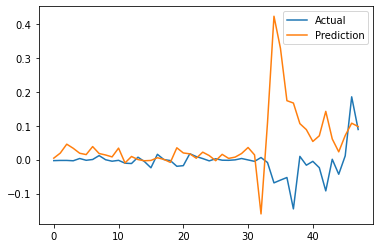

In [159]:
model_exvar = ['emp_mom_ch', 'emp_yoy_ch', 'emp', 'pce_mom_ch', 'pce_yoy_ch',
       'pce', 'cpi_mom_ch', 'cpi_yoy_ch', 'cpi', 'unemp_mom_ch',
       'unemp_yoy_ch', 'unemp', 'rrfs_mom_ch', 'rrfs_yoy_ch', 'rrfs',
       'rsxfs_mom_ch', 'rsxfs_yoy_ch', 'rsxfs', 'soc_mom_ch', 'soc_yoy_ch',
       'soc', 'COVID_Boolean', 'total_vaccinations', 'vac_mom_ch']

y = df['target']
y = np.array(y)

X = np.array(df[model_exvar])

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)

lr_model = LinearRegression().fit(x_train, y_train)
reg_pred = lr_model.predict(x_test)

plt.plot(y_test, label = "Actual")
plt.plot(reg_pred, label= 'Prediction')
plt.legend()
plt.show()

In [160]:
print("MAPE:", round(mape(y_test, reg_pred), 2))
print("MAE:", round(mae(y_test, reg_pred), 3))

MAPE: 10.07
MAE: 0.065


In [ ]:
def multi_step_pred(y_col, n_steps):
    for step in n_steps:
        col_name = str(y_col) + '_' + str(step)
        data[col_name] = data['RateDecision'].shift(step)
        df = data.dropna(subset = [col_name])

        X = df[feature_columns]
        X = X.dropna(axis='columns')
        feature_list = list(X.columns)
        X = np.array(X)
        y = np.array(df[col_name])

        # set random seed
        random.seed(42)
        np.random.seed(42)
        rand_seed = 42

        # split
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = random.randint(0,1000), shuffle = False)
        x_train, y_train = oversample.fit_resample(x_train, y_train)

        rf_model = RandomForestClassifier(bootstrap = False, criterion = 'gini', 
                                      max_depth = None, max_features = 8, min_samples_leaf = 10, 
                                      min_samples_split = 5, n_estimators = 500)

        rf_model = rf_model.fit(x_train, y_train)
        rf_predictions = rf_model.predict(x_test)

        # performance
        scores = rf_model.score(x_test, y_test)
        print(str(step) + '-Step Ahead Accuracy: ', scores)
        print(str(step) + '-Step Ahead ROC score: ', roc_auc_score(y_test, rf_model.predict_proba(x_test), multi_class='ovr'))

        # plot
        plt.plot(y_test, 'o', color='orange', label = "Actual")
        plt.plot(rf_predictions,  'x', color='blue', label = "Prediction")
        plt.title(str(step) + '-Ahead Prediction')
        plt.legend()
        plt.show()

        future_x = data[data.index == '2021-07-28']
        future_x = future_x.dropna(axis = 'columns')
        future_x = future_x[feature_columns]

        prediction = rf_model.predict(np.array(future_x))
        prediction = int(prediction)
        
        future_pred.append(prediction)
       
    return future_pred

In [ ]:
n_steps = list(range(1,13))
multi_step_pred('RateDecision', n_steps)